## Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

## Data Reading/Data Understanding

In [2]:
#Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train")
data_test = pathlib.Path('/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Test')

In [8]:
# Counting the number of images in train and test datasets

# Images from train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Images from test dataset
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [9]:
batch_size = 32
img_height = 180
img_width = 180

## Dataset Creation

In [10]:
#Creating train dataset. Here we use tf.keras.preprocessing.image_dataset_from_directory to generate train dataset
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
#Creating validation dataset. Here we use tf.keras.preprocessing.image_dataset_from_directory to generate validation dataset
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=42,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Dataset visualisation

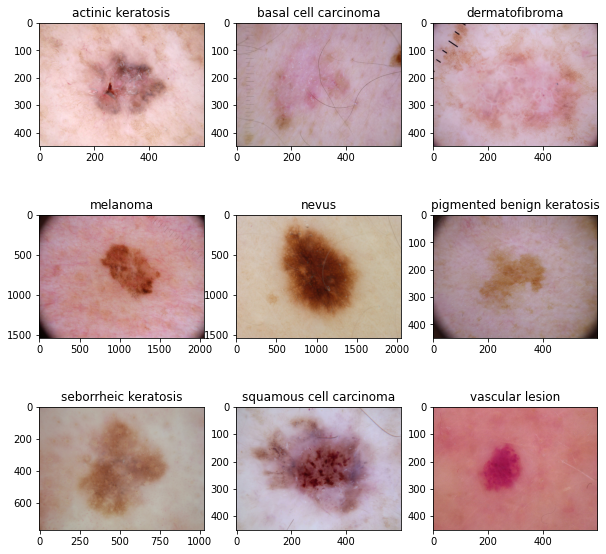

In [13]:
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [14]:
## Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

## Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & training

### Model Creation

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)      

### Model Compilation

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Training the Model

In [13]:
import warnings
warnings.filterwarnings("ignore") 
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 389s 1s/step - loss: 2.0652 - accuracy: 0.1975 - val_loss: 2.0273 - val_accuracy: 0.2125
Epoch 2/50
56/56 [==============================] - 1s 26ms/step - loss: 2.0294 - accuracy: 0.1931 - val_loss: 1.9833 - val_accuracy: 0.2081
Epoch 3/50
56/56 [==============================] - 1s 26ms/step - loss: 1.8940 - accuracy: 0.2919 - val_loss: 1.8662 - val_accuracy: 0.3020
Epoch 4/50
56/56 [==============================] - 1s 25ms/step - loss: 1.6943 - accuracy: 0.3940 - val_loss: 1.4535 - val_accuracy: 0.5056
Epoch 5/50
56/56 [==============================] - 1s 26ms/step - loss: 1.5533 - accuracy: 0.4515 - val_loss: 1.4518 - val_accuracy: 0.5347
Epoch 6/50
56/56 [==============================] - 1s 26ms/step - loss: 1.4768 - accuracy: 0.4877 - val_loss: 1.5112 - val_accuracy: 0.4765
Epoch 7/50
56/56 [==============================] - 1s 26ms/step - loss: 1.4764 - accuracy: 0.4827 - val_loss: 1.3922 - val_accuracy: 0.5213
Epoch 8/50
56

### Visualization of the Model

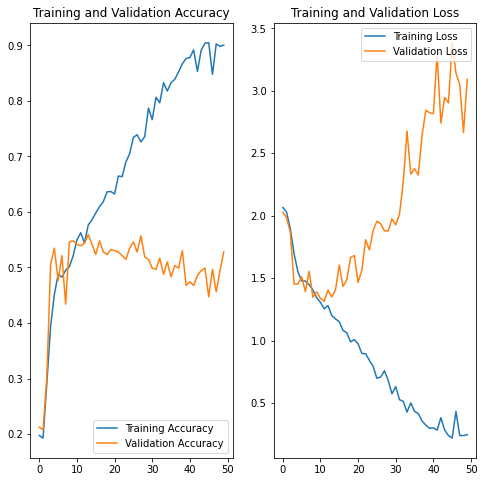

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations from Model Creation and Building
The data is overfitting

## Data Augmentation

### Augmenting the Data

In [15]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomContrast(factor = 1),
                             layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,  width_factor=0.2,fill_mode='reflect', interpolation='bilinear',seed=42,fill_value=0.0,)
])

### Visualizing the augmented data

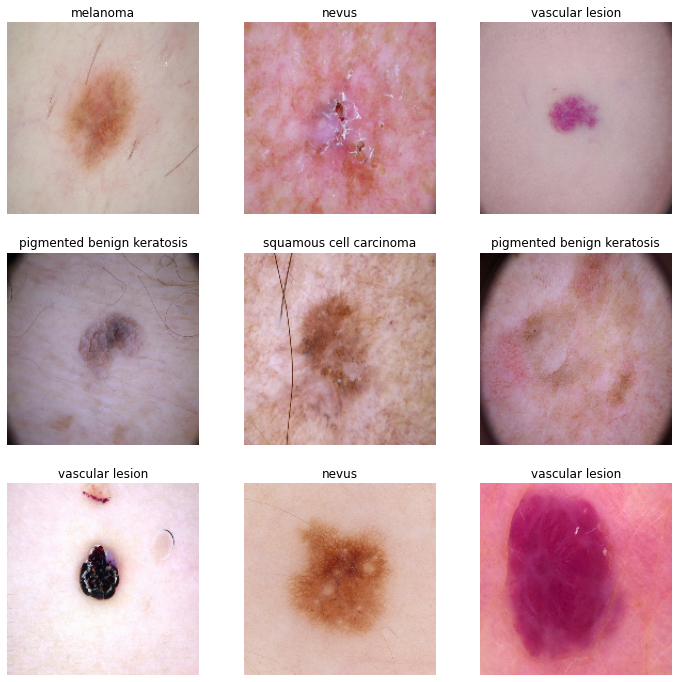

In [16]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model Building & Training on the Augmented Data

### Model Creation

In [17]:
num_classes = 9
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Model Compilation

In [18]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Model

In [19]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 4s 36ms/step - loss: 2.0239 - accuracy: 0.2221 - val_loss: 1.9969 - val_accuracy: 0.2707
Epoch 2/50
56/56 [==============================] - 2s 33ms/step - loss: 1.9712 - accuracy: 0.2628 - val_loss: 2.0217 - val_accuracy: 0.1924
Epoch 3/50
56/56 [==============================] - 2s 32ms/step - loss: 1.8623 - accuracy: 0.3013 - val_loss: 1.6556 - val_accuracy: 0.3848
Epoch 4/50
56/56 [==============================] - 2s 32ms/step - loss: 1.7357 - accuracy: 0.3471 - val_loss: 1.7496 - val_accuracy: 0.3893
Epoch 5/50
56/56 [==============================] - 2s 33ms/step - loss: 1.6667 - accuracy: 0.3783 - val_loss: 1.5201 - val_accuracy: 0.4452
Epoch 6/50
56/56 [==============================] - 2s 32ms/step - loss: 1.6626 - accuracy: 0.3912 - val_loss: 1.4662 - val_accuracy: 0.4787
Epoch 7/50
56/56 [==============================] - 2s 32ms/step - loss: 1.6298 - accuracy: 0.4029 - val_loss: 1.4896 - val_accuracy: 0.5034
Epoch 8/50
56

### Visualizing the Trained Data

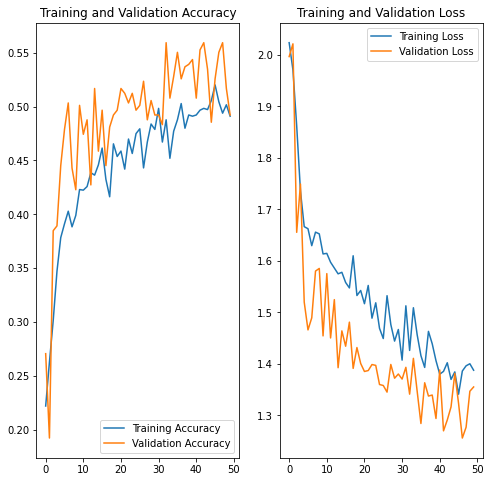

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Examining the Class Distribution

In [16]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion


In [17]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
1,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
2,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
3,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
4,/content/drive/MyDrive/Melanoma Detection- Ash...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2235,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2236,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion
2237,/content/drive/MyDrive/Melanoma Detection- Ash...,vascular lesion


### Checking the number of images per class (Disease)

### Visualizing the results of class distribution

<BarContainer object of 9 artists>

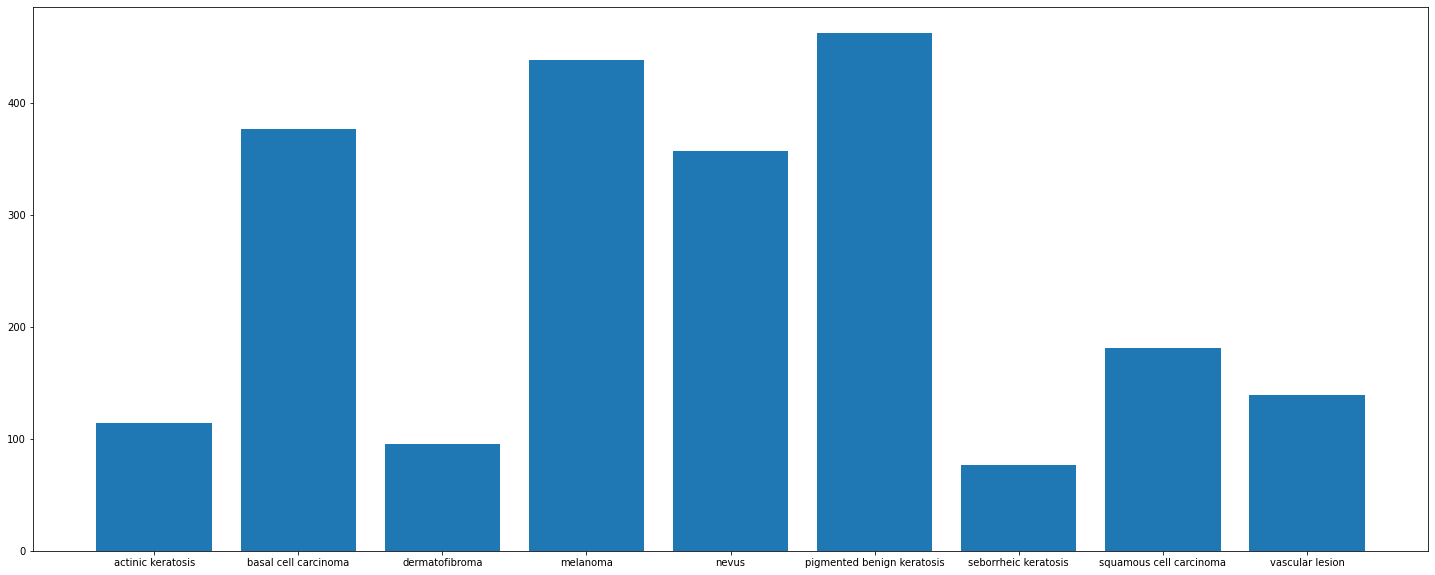

In [18]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [19]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### *Observations from Class Distribution Examination*

- All the classes have different number of images. Therefore the dataset is imbalanced.

- Pigmented Benign Keratosis has the maximum number of images - 462

- Seborrheic Keratosis has the minimum number of images - 77

## Rectifying the Class Imbalance
Here we will be using the Augmentor Library to rectify the class imbalance. It will add more samples across all classes so that none of the classes have very few samples.

In [20]:
! pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
path_to_training_dataset="/content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/"

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i,save_format='jpg')
    
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
	  
    p.shear(probability=0.7, max_shear_left=2, max_shear_right=2)
	  
    p.flip_random(probability=0.7)
    
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49F9134810>: 100%|██████████| 500/500 [00:30<00:00, 16.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49F911FD10>: 100%|██████████| 500/500 [00:30<00:00, 16.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49F91143D0>: 100%|██████████| 500/500 [00:28<00:00, 17.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F49F97D2B90>: 100%|██████████| 500/500 [02:17<00:00,  3.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F49FB998090>: 100%|██████████| 500/500 [02:27<00:00,  3.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49FBE4C150>: 100%|██████████| 500/500 [00:28<00:00, 17.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F49FBE6B4D0>: 100%|██████████| 500/500 [01:06<00:00,  7.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49F868A2D0>: 100%|██████████| 500/500 [00:28<00:00, 17.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Detection- Ashwini Abhang/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F49F910FF50>: 100%|██████████| 500/500 [00:26<00:00, 18.69 Samples/s]


In [5]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Observing the distribution of augmented data after adding new images to the original training data.

In [6]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=42,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=42,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [25]:
batch_size = 32
img_height = 180
img_width = 180

## Model Building & training on the rectified class imbalance data 
### Expermenting with different layers

#### 4 CNN Layers i.e. with 256 filter layer

In [33]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)      

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-512-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [35]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.9237 - accuracy: 0.2552
Epoch 1: val_accuracy improved from -inf to 0.37342, saving model to model-512-128.h5
169/169 [==============================] - 31s 176ms/step - loss: 1.9228 - accuracy: 0.2548 - val_loss: 1.6034 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.5968 - accuracy: 0.3874
Epoch 2: val_accuracy improved from 0.37342 to 0.39718, saving model to model-512-128.h5
169/169 [==============================] - 32s 180ms/step - loss: 1.5969 - accuracy: 0.3874 - val_loss: 1.4994 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.5222 - accuracy: 0.4102
Epoch 3: val_accuracy improved from 0.39718 to 0.44692, saving model to model-512-128.h5
169/169 [==============================] - 30s 169ms/step - loss: 1.5207 - accuracy: 0.4099 - val_loss: 1.4197 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 4

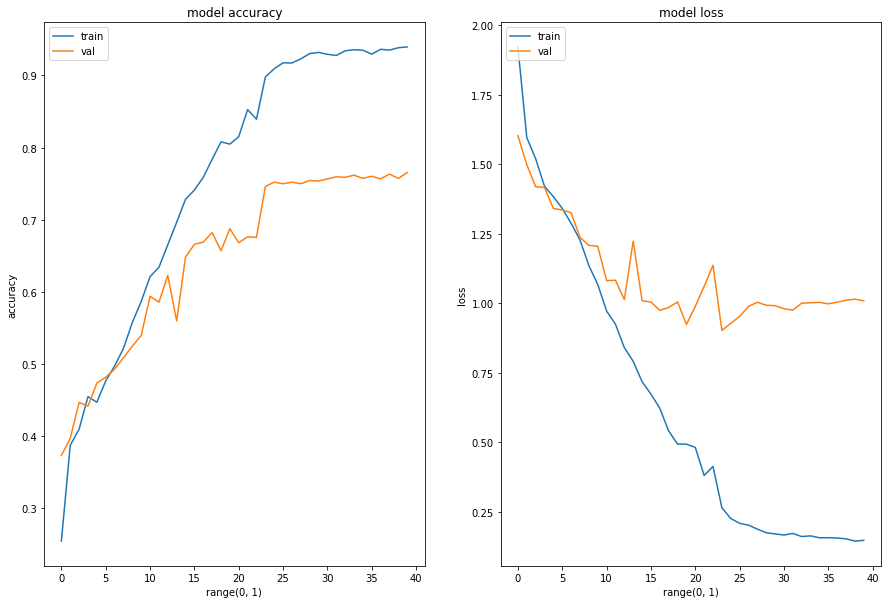

In [36]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 41, 41, 128)      

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-512.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [39]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.9557 - accuracy: 0.2494
Epoch 1: val_accuracy improved from -inf to 0.39941, saving model to model-512.h5
169/169 [==============================] - 40s 175ms/step - loss: 1.9568 - accuracy: 0.2493 - val_loss: 1.6100 - val_accuracy: 0.3994 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.6082 - accuracy: 0.3830
Epoch 2: val_accuracy improved from 0.39941 to 0.42242, saving model to model-512.h5
169/169 [==============================] - 31s 175ms/step - loss: 1.6064 - accuracy: 0.3845 - val_loss: 1.5168 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.4936 - accuracy: 0.4268
Epoch 3: val_accuracy improved from 0.42242 to 0.43356, saving model to model-512.h5
169/169 [==============================] - 30s 170ms/step - loss: 1.4920 - accuracy: 0.4273 - val_loss: 1.4016 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 4/40
167/169 

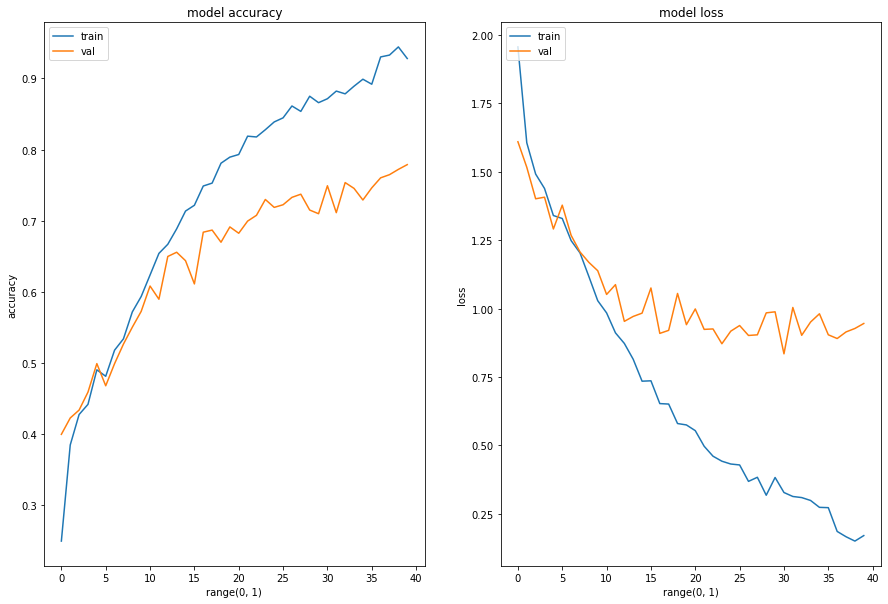

In [40]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 41, 41, 128)      

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-256.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [45]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.8755 - accuracy: 0.2695
Epoch 1: val_accuracy improved from -inf to 0.39124, saving model to model-256.h5
169/169 [==============================] - 32s 177ms/step - loss: 1.8738 - accuracy: 0.2710 - val_loss: 1.5878 - val_accuracy: 0.3912 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.5740 - accuracy: 0.4036
Epoch 2: val_accuracy improved from 0.39124 to 0.39866, saving model to model-256.h5
169/169 [==============================] - 31s 175ms/step - loss: 1.5741 - accuracy: 0.4041 - val_loss: 1.5270 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.4778 - accuracy: 0.4397
Epoch 3: val_accuracy improved from 0.39866 to 0.44840, saving model to model-256.h5
169/169 [==============================] - 30s 169ms/step - loss: 1.4779 - accuracy: 0.4401 - val_loss: 1.4189 - val_accuracy: 0.4484 - lr: 0.0010
Epoch 4/40
167/169 

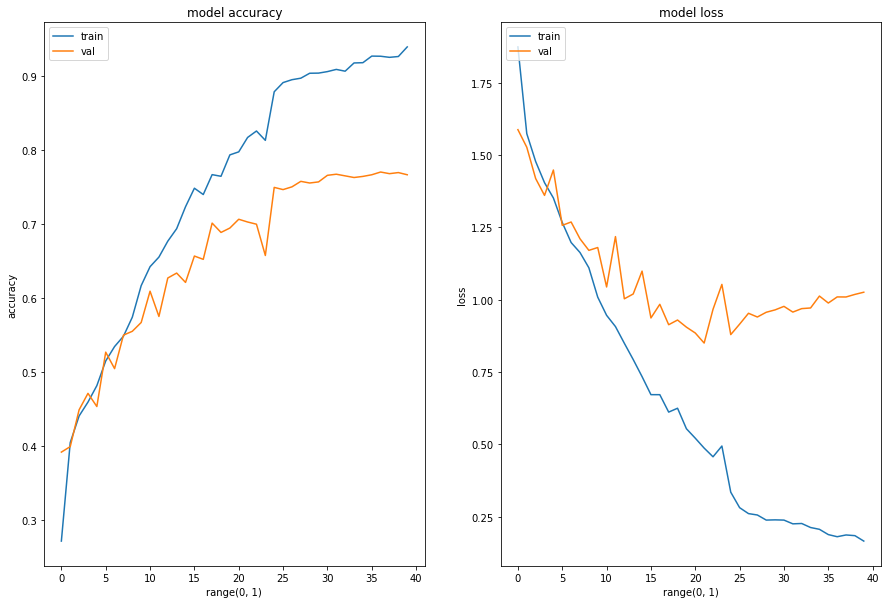

In [46]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 41, 41, 128)      

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [49]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 2.0779 - accuracy: 0.1940
Epoch 1: val_accuracy improved from -inf to 0.26726, saving model to model-128.h5
169/169 [==============================] - 31s 174ms/step - loss: 2.0759 - accuracy: 0.1949 - val_loss: 1.8627 - val_accuracy: 0.2673 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.7525 - accuracy: 0.3256
Epoch 2: val_accuracy improved from 0.26726 to 0.38901, saving model to model-128.h5
169/169 [==============================] - 30s 168ms/step - loss: 1.7515 - accuracy: 0.3259 - val_loss: 1.5850 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.6148 - accuracy: 0.3802
Epoch 3: val_accuracy improved from 0.38901 to 0.42984, saving model to model-128.h5
169/169 [==============================] - 32s 183ms/step - loss: 1.6143 - accuracy: 0.3802 - val_loss: 1.4284 - val_accuracy: 0.4298 - lr: 0.0010
Epoch 4/40
167/169 

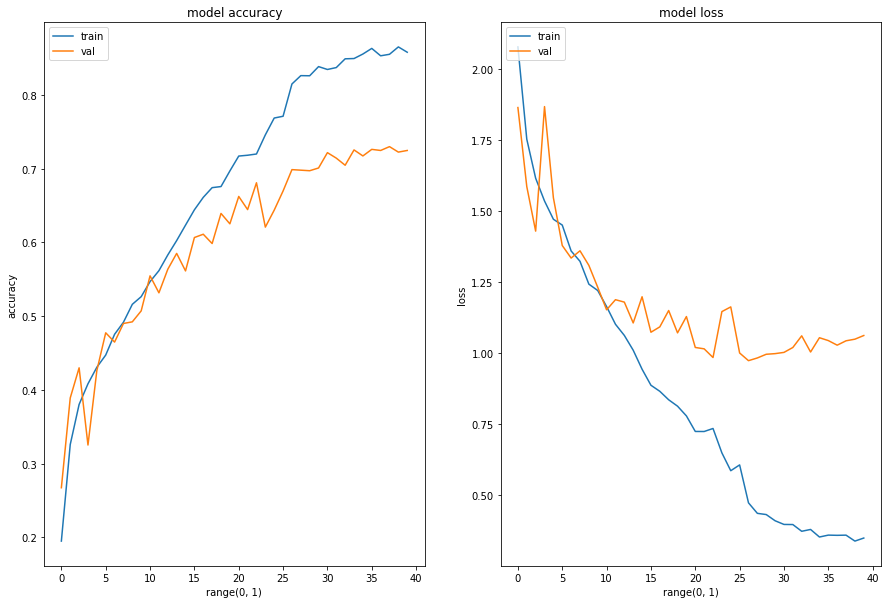

In [50]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 41, 41, 128)      

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model-512-256-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [54]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.8279 - accuracy: 0.2826
Epoch 1: val_accuracy improved from 0.25167 to 0.34744, saving model to model-512-256-128.h5
169/169 [==============================] - 30s 171ms/step - loss: 1.8288 - accuracy: 0.2825 - val_loss: 1.6592 - val_accuracy: 0.3474 - lr: 0.0010
Epoch 2/40
169/169 [==============================] - ETA: 0s - loss: 1.7036 - accuracy: 0.3563
Epoch 2: val_accuracy improved from 0.34744 to 0.40460, saving model to model-512-256-128.h5
169/169 [==============================] - 31s 179ms/step - loss: 1.7036 - accuracy: 0.3563 - val_loss: 1.5190 - val_accuracy: 0.4046 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.5574 - accuracy: 0.4021
Epoch 3: val_accuracy improved from 0.40460 to 0.41945, saving model to model-512-256-128.h5
169/169 [==============================] - 31s 175ms/step - loss: 1.5584 - accuracy: 0.4021 - val_loss: 1.4562 - val_accuracy: 0.4195 - lr:

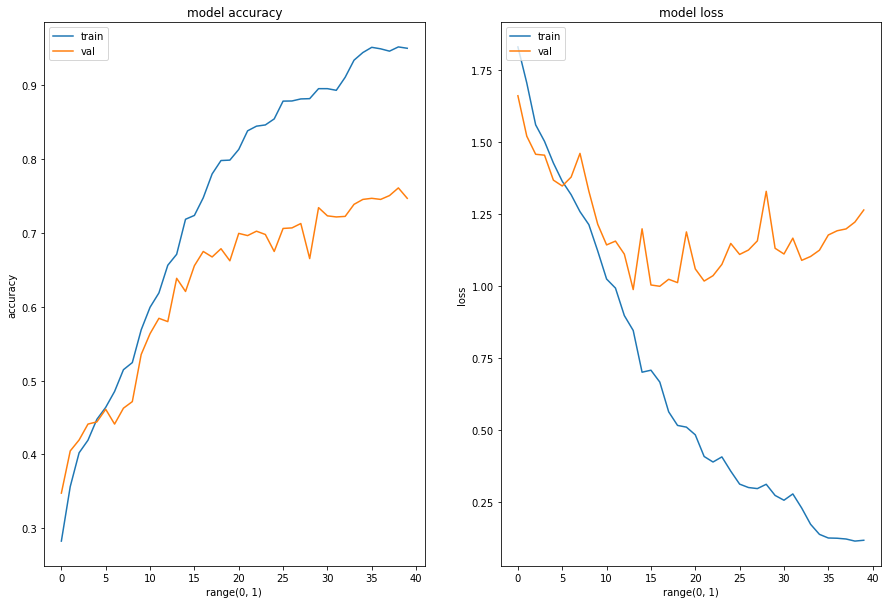

In [55]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 3 CNN layers i.e. Without 256 filter layers

In [3]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-512-256-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [9]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
169/169 [==============================] - ETA: 0s - loss: 2.0803 - accuracy: 0.1921
Epoch 1: val_accuracy improved from -inf to 0.30438, saving model to modelw/o256layer-512-256-128.h5
169/169 [==============================] - 856s 5s/step - loss: 2.0803 - accuracy: 0.1921 - val_loss: 1.8276 - val_accuracy: 0.3044 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.6940 - accuracy: 0.3496
Epoch 2: val_accuracy improved from 0.30438 to 0.40535, saving model to modelw/o256layer-512-256-128.h5
169/169 [==============================] - 33s 187ms/step - loss: 1.6938 - accuracy: 0.3509 - val_loss: 1.5300 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.5223 - accuracy: 0.4134
Epoch 3: val_accuracy improved from 0.40535 to 0.43059, saving model to modelw/o256layer-512-256-128.h5
169/169 [==============================] - 32s 181ms/step - loss: 1.5230 - accuracy: 0.4121 - val_loss: 1.4200 

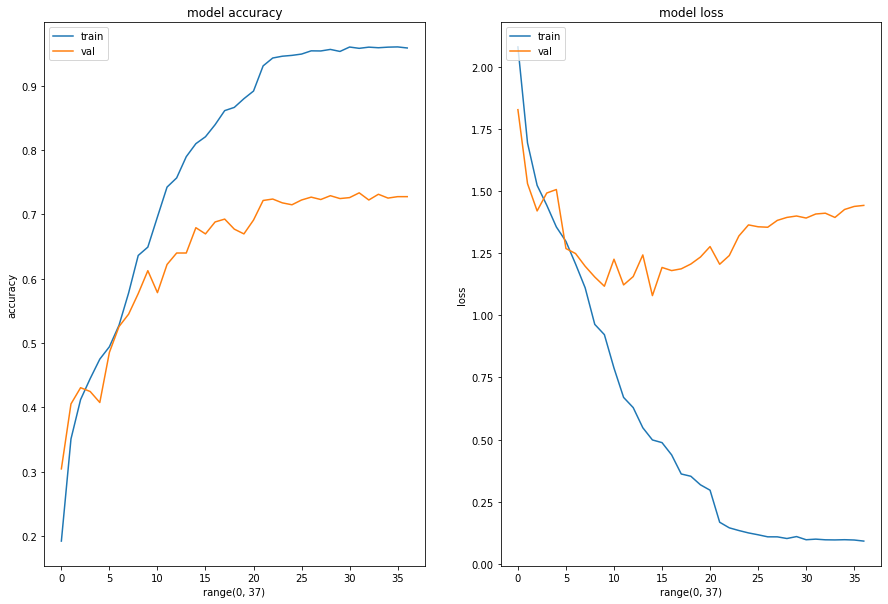

In [10]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-256-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [13]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 2.0605 - accuracy: 0.2090
Epoch 1: val_accuracy improved from -inf to 0.34967, saving model to modelw/o256layer-256-128.h5
169/169 [==============================] - 34s 190ms/step - loss: 2.0587 - accuracy: 0.2103 - val_loss: 1.7896 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.6417 - accuracy: 0.3743
Epoch 2: val_accuracy improved from 0.34967 to 0.42465, saving model to modelw/o256layer-256-128.h5
169/169 [==============================] - 32s 180ms/step - loss: 1.6410 - accuracy: 0.3746 - val_loss: 1.5624 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.4853 - accuracy: 0.4259
Epoch 3: val_accuracy improved from 0.42465 to 0.46474, saving model to modelw/o256layer-256-128.h5
169/169 [==============================] - 32s 183ms/step - loss: 1.4847 - accuracy: 0.4260 - val_loss: 1.4103 - val_accu

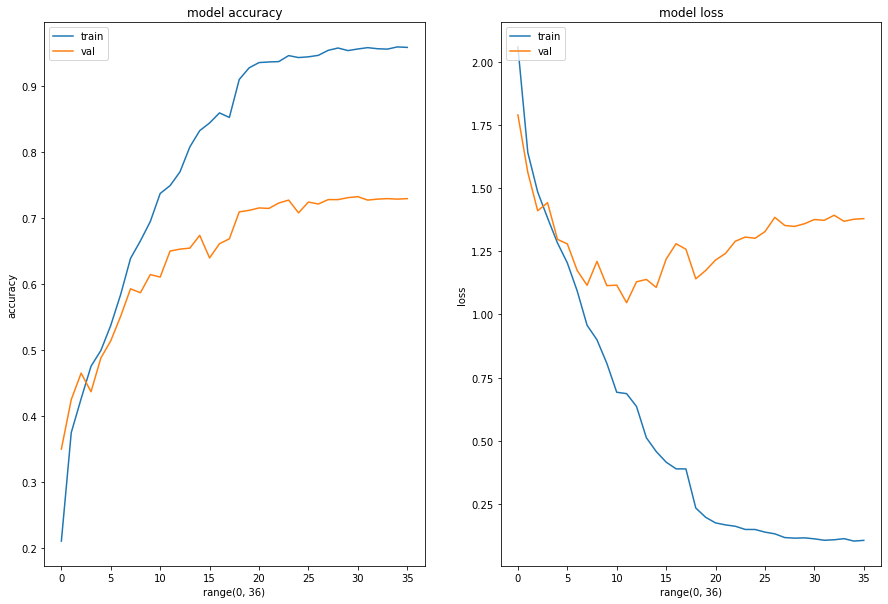

In [14]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [17]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.8958 - accuracy: 0.2745
Epoch 1: val_accuracy improved from -inf to 0.40535, saving model to modelw/o256layer-128.h5
169/169 [==============================] - 31s 170ms/step - loss: 1.8931 - accuracy: 0.2754 - val_loss: 1.5187 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 2/40
168/169 [============================>.] - ETA: 0s - loss: 1.5454 - accuracy: 0.4196
Epoch 2: val_accuracy improved from 0.40535 to 0.41574, saving model to modelw/o256layer-128.h5
169/169 [==============================] - 31s 178ms/step - loss: 1.5470 - accuracy: 0.4190 - val_loss: 1.5105 - val_accuracy: 0.4157 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.4307 - accuracy: 0.4517
Epoch 3: val_accuracy improved from 0.41574 to 0.47142, saving model to modelw/o256layer-128.h5
169/169 [==============================] - 29s 168ms/step - loss: 1.4271 - accuracy: 0.4527 - val_loss: 1.4125 - val_accuracy: 0.4714

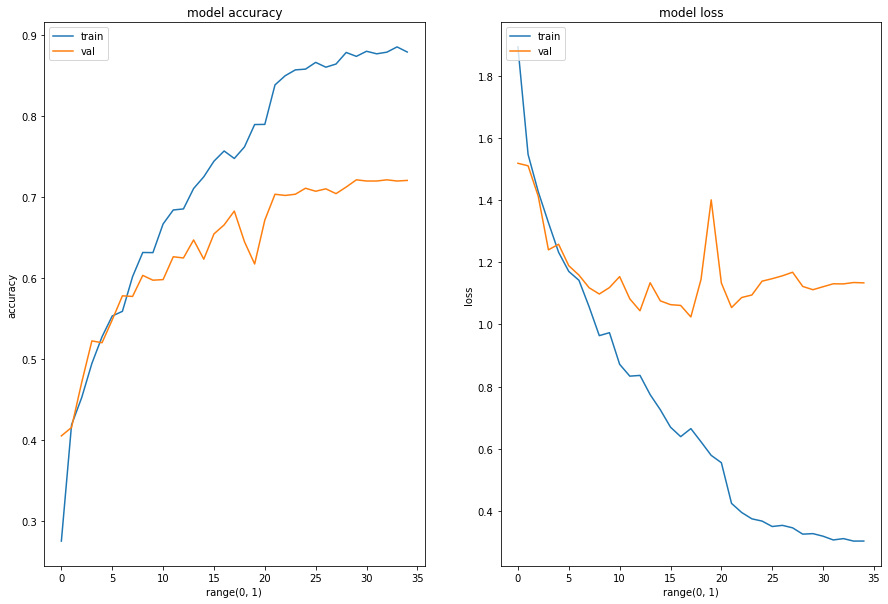

In [20]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-512-256.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [21]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 2.1129 - accuracy: 0.2096
Epoch 1: val_accuracy improved from -inf to 0.27765, saving model to modelw/o256layer-512-256.h5
169/169 [==============================] - 31s 174ms/step - loss: 2.1098 - accuracy: 0.2099 - val_loss: 1.8344 - val_accuracy: 0.2777 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.6842 - accuracy: 0.3467
Epoch 2: val_accuracy improved from 0.27765 to 0.38679, saving model to modelw/o256layer-512-256.h5
169/169 [==============================] - 32s 183ms/step - loss: 1.6841 - accuracy: 0.3463 - val_loss: 1.5265 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 3/40
169/169 [==============================] - ETA: 0s - loss: 1.5044 - accuracy: 0.4117
Epoch 3: val_accuracy improved from 0.38679 to 0.44618, saving model to modelw/o256layer-512-256.h5
169/169 [==============================] - 31s 179ms/step - loss: 1.5044 - accuracy: 0.4117 - val_loss: 1.3731 - val_accu

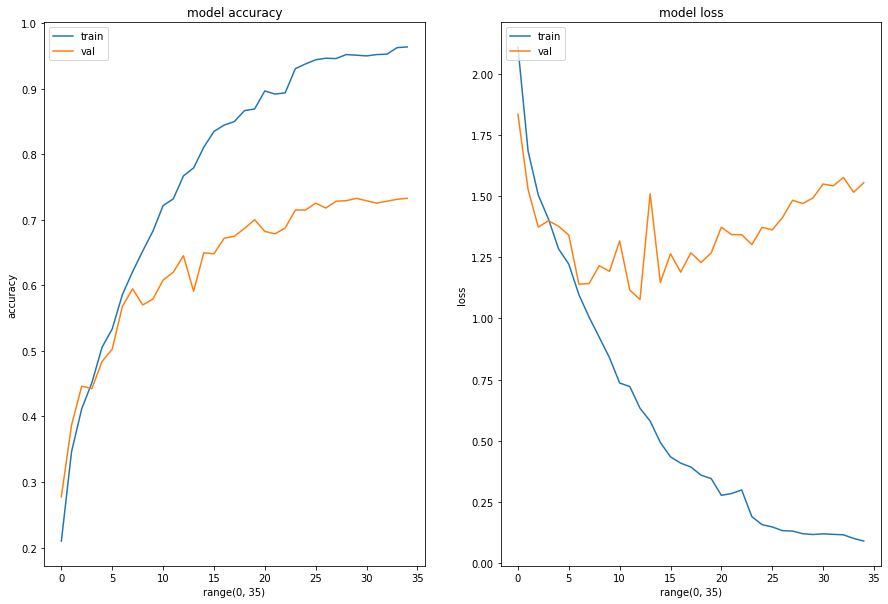

In [22]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-512-128.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [25]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.9181 - accuracy: 0.2708
Epoch 1: val_accuracy improved from -inf to 0.39050, saving model to modelw/o256layer-512-128.h5
169/169 [==============================] - 32s 178ms/step - loss: 1.9146 - accuracy: 0.2719 - val_loss: 1.6444 - val_accuracy: 0.3905 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.6061 - accuracy: 0.3907
Epoch 2: val_accuracy improved from 0.39050 to 0.43430, saving model to modelw/o256layer-512-128.h5
169/169 [==============================] - 33s 191ms/step - loss: 1.6059 - accuracy: 0.3909 - val_loss: 1.4712 - val_accuracy: 0.4343 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.4725 - accuracy: 0.4321
Epoch 3: val_accuracy improved from 0.43430 to 0.45805, saving model to modelw/o256layer-512-128.h5
169/169 [==============================] - 33s 188ms/step - loss: 1.4713 - accuracy: 0.4329 - val_loss: 1.4116 - val_accu

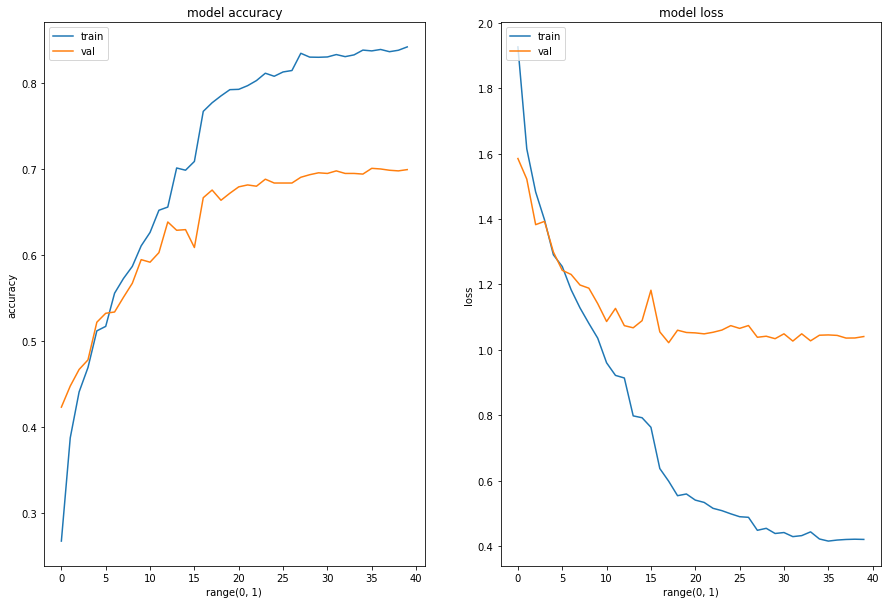

In [38]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer

model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 41, 41, 128)      

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-256.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [43]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.6111 - accuracy: 0.3815
Epoch 1: val_accuracy improved from -inf to 0.38159, saving model to modelw/o256layer-256.h5
169/169 [==============================] - 78s 180ms/step - loss: 1.6109 - accuracy: 0.3813 - val_loss: 1.6940 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.4375 - accuracy: 0.4532
Epoch 2: val_accuracy improved from 0.38159 to 0.46993, saving model to modelw/o256layer-256.h5
169/169 [==============================] - 30s 172ms/step - loss: 1.4375 - accuracy: 0.4523 - val_loss: 1.3629 - val_accuracy: 0.4699 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.3474 - accuracy: 0.4848
Epoch 3: val_accuracy did not improve from 0.46993
169/169 [==============================] - 30s 170ms/step - loss: 1.3496 - accuracy: 0.4837 - val_loss: 1.4677 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 4/40
167/169 [===========

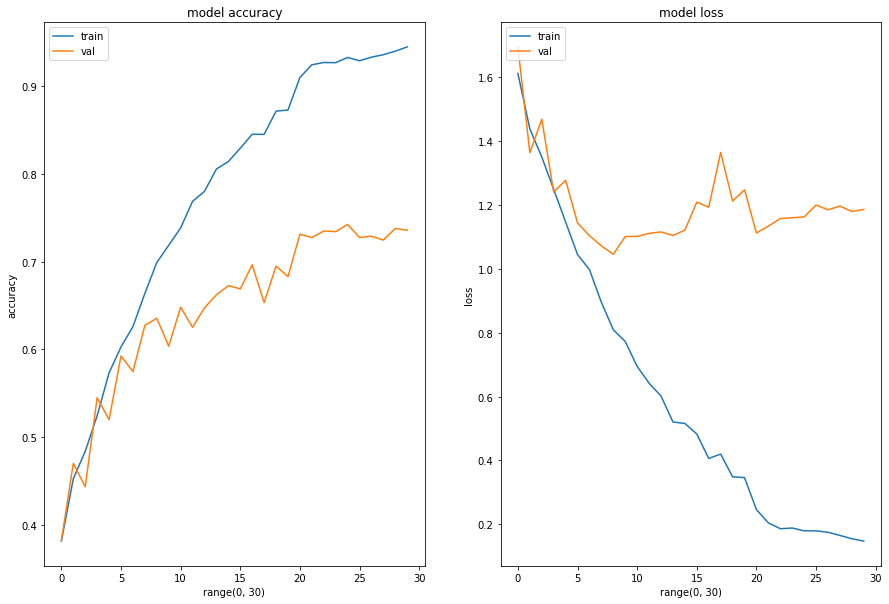

In [44]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer

model.add(layers.Dense(512,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 41, 41, 128)     

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("modelw/o256layer-512.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.000005)

In [48]:
# Train the model
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop,lr_callback])

Epoch 1/40
167/169 [============================>.] - ETA: 0s - loss: 1.9117 - accuracy: 0.2734
Epoch 1: val_accuracy improved from -inf to 0.41574, saving model to modelw/o256layer-512.h5
169/169 [==============================] - 34s 189ms/step - loss: 1.9111 - accuracy: 0.2741 - val_loss: 1.5319 - val_accuracy: 0.4157 - lr: 0.0010
Epoch 2/40
167/169 [============================>.] - ETA: 0s - loss: 1.5244 - accuracy: 0.4251
Epoch 2: val_accuracy improved from 0.41574 to 0.46548, saving model to modelw/o256layer-512.h5
169/169 [==============================] - 31s 179ms/step - loss: 1.5214 - accuracy: 0.4260 - val_loss: 1.4418 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 3/40
167/169 [============================>.] - ETA: 0s - loss: 1.3729 - accuracy: 0.4817
Epoch 3: val_accuracy improved from 0.46548 to 0.49592, saving model to modelw/o256layer-512.h5
169/169 [==============================] - 31s 179ms/step - loss: 1.3758 - accuracy: 0.4803 - val_loss: 1.3806 - val_accuracy: 0.4959

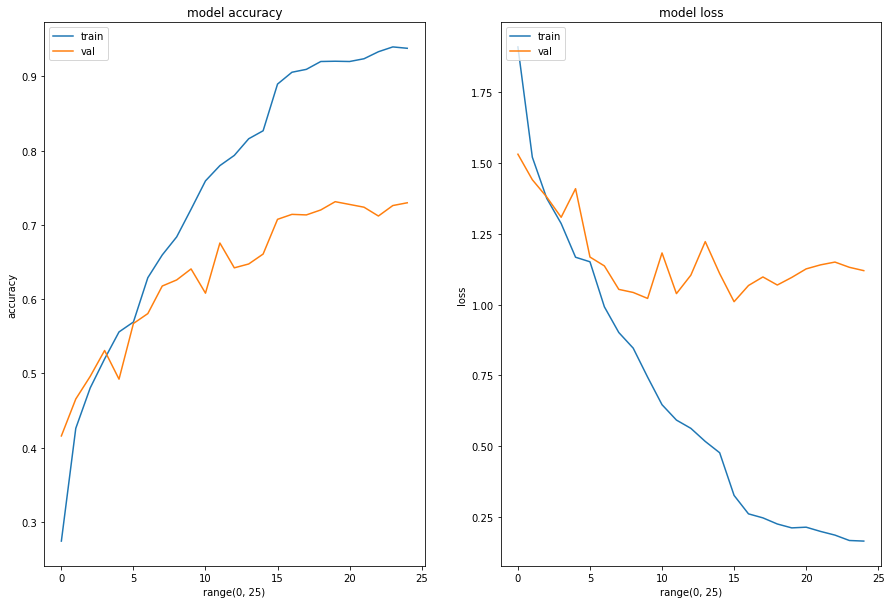

In [49]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()